# 1. Import the libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import time

# 2. Load the Letter Recognition data.
## Pull data online and rename the columns.

In [24]:
raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data',header=None, sep = ',')
features = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
raw_data.columns = features

# 3. Find the pairs and make them a new data set.
## 3.1 Pair 1: H and K; 

In [25]:
HK = raw_data[raw_data['lettr'].isin(['H', 'K'])]

HK = HK.reset_index(drop=True)
HK_X_train, HK_X_test, HK_y_train, HK_y_test = train_test_split(HK.drop('lettr', axis=1), HK['lettr'], test_size=0.1, random_state=514)
# Reset index of HK_X_train
HK_X_train = HK_X_train.reset_index(drop=True)

# Reset index of HK_X_test
HK_X_test = HK_X_test.reset_index(drop=True)

# Reset index of HK_y_train
HK_y_train = HK_y_train.reset_index(drop=True)

# Reset index of HK_y_test
HK_y_test = HK_y_test.reset_index(drop=True)



## 3.2 Pair 2: M and Y;

In [26]:
MY = raw_data[raw_data['lettr'].isin(['M', 'Y'])]
MY = MY.reset_index(drop=True)
MY_X_train, MY_X_test, MY_y_train, MY_y_test = train_test_split(MY.drop('lettr', axis=1), MY['lettr'], test_size=0.1, random_state=514)

MY_X_train = MY_X_train.reset_index(drop=True)

MY_X_test = MY_X_test.reset_index(drop=True)

MY_y_train = MY_y_train.reset_index(drop=True)

MY_y_test = MY_y_test.reset_index(drop=True)


## 3.3 Pair 3: X and T;

In [27]:
XT = raw_data[raw_data['lettr'].isin(['X','T'])]
XT = XT.reset_index(drop=True)
XT_X_train, XT_X_test, XT_y_train, XT_y_test = train_test_split(XT.drop('lettr', axis=1), XT['lettr'], test_size=0.1, random_state=514)

XT_X_train = XT_X_train.reset_index(drop=True)

XT_X_test = XT_X_test.reset_index(drop=True)

XT_y_train = XT_y_train.reset_index(drop=True)

XT_y_test = XT_y_test.reset_index(drop=True)


## Distribution check

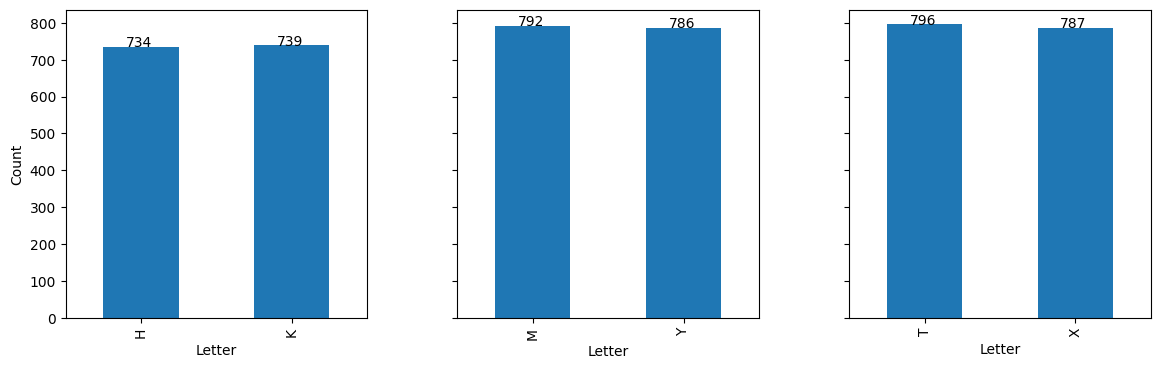

In [28]:
# Create subplots for three different pairs
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

# Plot the distribution of the target variable for each pair
HK['lettr'].value_counts().sort_index().plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Letter')
axs[0].set_ylabel('Count')
for i, v in enumerate(HK['lettr'].value_counts().sort_index()):
    axs[0].text(i - 0.1, v + 0.2, str(v))

MY['lettr'].value_counts().sort_index().plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Letter')
axs[1].set_ylabel('Count')
for i, v in enumerate(MY['lettr'].value_counts().sort_index()):
    axs[1].text(i - 0.1, v + 0.2, str(v))

XT['lettr'].value_counts().sort_index().plot(kind='bar', ax=axs[2])
axs[2].set_xlabel('Letter')
axs[2].set_ylabel('Count')
for i, v in enumerate(XT['lettr'].value_counts().sort_index()):
    axs[2].text(i - 0.1, v + 0.2, str(v))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.show()

## Check the outliers for each pairs.

### 1. Pair H & K

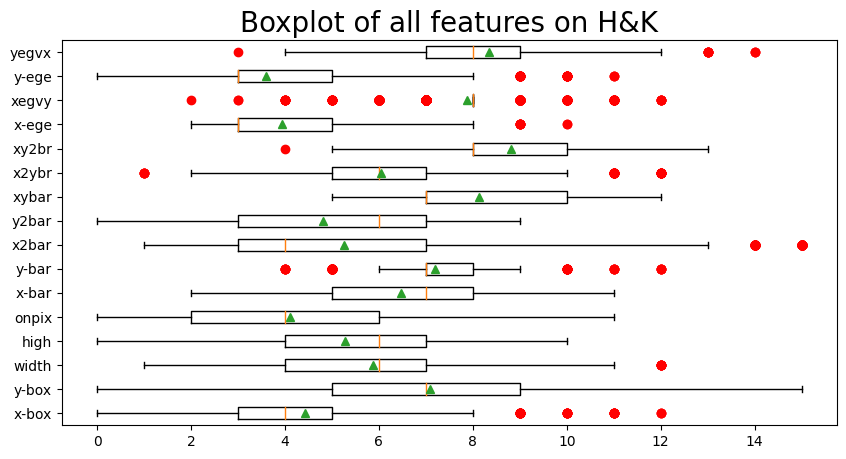

In [29]:
plt.figure(figsize=(10,5))
plt.title('Boxplot of all features on H&K',fontsize=20)
label = features[1:]
plt.boxplot(HK.drop('lettr', axis=1), vert=False,showmeans=True,sym='ro')
ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.yticks( ticks,label)
plt.show()
print()

In [30]:
outlier_index = []
for feature in list(HK.drop('lettr', axis=1).columns):

    q1 = HK[feature].quantile(0.25)
    q3 = HK[feature].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print("Upper Boundary:", upper)
    print("Lower Boundary:", lower, '\n')
    print("Non outlier range:", [lower, upper])

    ##### Detect the outliers. #####
    outlier = HK.drop('lettr', axis=1)[feature][(HK.drop('lettr', axis=1)[feature] < lower) | (HK.drop('lettr', axis=1)[feature] > upper)]
    print("Total number of outliers for {}: {}".format(feature, len(outlier)))
    indexDF = pd.DataFrame(outlier)
    if indexDF.size == 0:
        print("-" * 20)
        continue
    else:
        outlier_index += list(indexDF.index)

    print("-" * 20)

outlier_index = set(outlier_index)
print(len(outlier_index))

Upper Boundary: 8.0
Lower Boundary: 0.0 

Non outlier range: [0.0, 8.0]
Total number of outliers for x-box: 42
--------------------
Upper Boundary: 15.0
Lower Boundary: -1.0 

Non outlier range: [-1.0, 15.0]
Total number of outliers for y-box: 0
--------------------
Upper Boundary: 11.5
Lower Boundary: -0.5 

Non outlier range: [-0.5, 11.5]
Total number of outliers for width: 8
--------------------
Upper Boundary: 11.5
Lower Boundary: -0.5 

Non outlier range: [-0.5, 11.5]
Total number of outliers for high: 0
--------------------
Upper Boundary: 12.0
Lower Boundary: -4.0 

Non outlier range: [-4.0, 12.0]
Total number of outliers for onpix: 0
--------------------
Upper Boundary: 12.5
Lower Boundary: 0.5 

Non outlier range: [0.5, 12.5]
Total number of outliers for x-bar: 0
--------------------
Upper Boundary: 9.5
Lower Boundary: 5.5 

Non outlier range: [5.5, 9.5]
Total number of outliers for y-bar: 82
--------------------
Upper Boundary: 13.0
Lower Boundary: -3.0 

Non outlier range: [

### 2. Pair M & Y

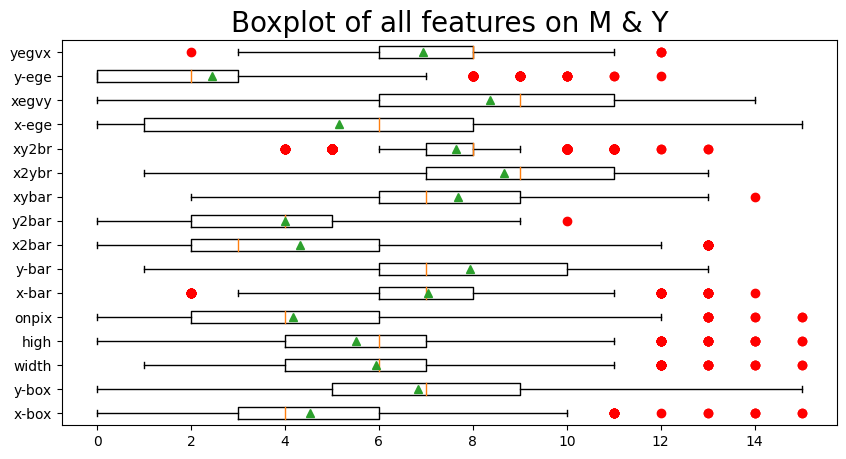

In [31]:
plt.figure(figsize=(10,5))
plt.title('Boxplot of all features on M & Y',fontsize=20)
label = features[1:]
plt.boxplot(MY.drop('lettr', axis=1), vert=False,showmeans=True,sym='ro')
ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.yticks( ticks,label)
plt.show()
print()

In [32]:
outlier_index = []
for feature in list(MY.drop('lettr', axis=1).columns):

    q1 = MY[feature].quantile(0.25)
    q3 = MY[feature].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print("Upper Boundary:", upper)
    print("Lower Boundary:", lower, '\n')
    print("Non outlier range:", [lower, upper])

    ##### Detect the outliers. #####
    outlier = MY.drop('lettr', axis=1)[feature][(MY.drop('lettr', axis=1)[feature] < lower) | (MY.drop('lettr', axis=1)[feature] > upper)]
    print("Total number of outliers for {}: {}".format(feature, len(outlier)))
    indexDF = pd.DataFrame(outlier)
    if indexDF.size == 0:
        print("-" * 20)
        continue
    else:
        outlier_index += list(indexDF.index)

    print("-" * 20)

outlier_index = set(outlier_index)
print(len(outlier_index))

Upper Boundary: 10.5
Lower Boundary: -1.5 

Non outlier range: [-1.5, 10.5]
Total number of outliers for x-box: 18
--------------------
Upper Boundary: 15.0
Lower Boundary: -1.0 

Non outlier range: [-1.0, 15.0]
Total number of outliers for y-box: 0
--------------------
Upper Boundary: 11.5
Lower Boundary: -0.5 

Non outlier range: [-0.5, 11.5]
Total number of outliers for width: 25
--------------------
Upper Boundary: 11.5
Lower Boundary: -0.5 

Non outlier range: [-0.5, 11.5]
Total number of outliers for high: 25
--------------------
Upper Boundary: 12.0
Lower Boundary: -4.0 

Non outlier range: [-4.0, 12.0]
Total number of outliers for onpix: 10
--------------------
Upper Boundary: 11.0
Lower Boundary: 3.0 

Non outlier range: [3.0, 11.0]
Total number of outliers for x-bar: 42
--------------------
Upper Boundary: 16.0
Lower Boundary: 0.0 

Non outlier range: [0.0, 16.0]
Total number of outliers for y-bar: 0
--------------------
Upper Boundary: 12.0
Lower Boundary: -4.0 

Non outlier

### 3. Pair X & T

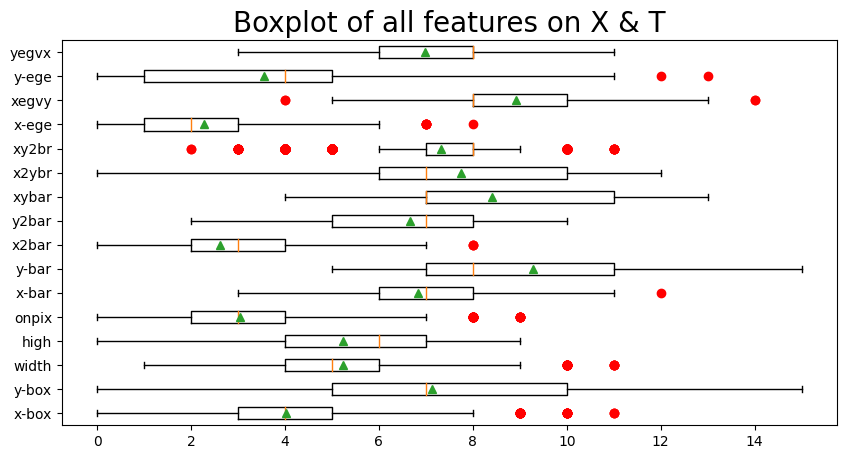

In [33]:
plt.figure(figsize=(10,5))
plt.title('Boxplot of all features on X & T',fontsize=20)
label = features[1:]
plt.boxplot(XT.drop('lettr', axis=1), vert=False,showmeans=True,sym='ro')
ticks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.yticks( ticks,label)
plt.show()
print()

In [34]:
outlier_index = []
for feature in list(XT.drop('lettr', axis=1).columns):

    q1 = XT[feature].quantile(0.25)
    q3 = XT[feature].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print("Upper Boundary:", upper)
    print("Lower Boundary:", lower, '\n')
    print("Non outlier range:", [lower, upper])

    ##### Detect the outliers. #####
    outlier = XT.drop('lettr', axis=1)[feature][(XT.drop('lettr', axis=1)[feature] < lower) | (XT.drop('lettr', axis=1)[feature] > upper)]
    print("Total number of outliers for {}: {}".format(feature, len(outlier)))
    indexDF = pd.DataFrame(outlier)
    if indexDF.size == 0:
        print("-" * 20)
        continue
    else:
        outlier_index += list(indexDF.index)

    print("-" * 20)

outlier_index = set(outlier_index)
print(len(outlier_index))

Upper Boundary: 8.0
Lower Boundary: 0.0 

Non outlier range: [0.0, 8.0]
Total number of outliers for x-box: 35
--------------------
Upper Boundary: 17.5
Lower Boundary: -2.5 

Non outlier range: [-2.5, 17.5]
Total number of outliers for y-box: 0
--------------------
Upper Boundary: 9.0
Lower Boundary: 1.0 

Non outlier range: [1.0, 9.0]
Total number of outliers for width: 26
--------------------
Upper Boundary: 11.5
Lower Boundary: -0.5 

Non outlier range: [-0.5, 11.5]
Total number of outliers for high: 0
--------------------
Upper Boundary: 7.0
Lower Boundary: -1.0 

Non outlier range: [-1.0, 7.0]
Total number of outliers for onpix: 33
--------------------
Upper Boundary: 11.0
Lower Boundary: 3.0 

Non outlier range: [3.0, 11.0]
Total number of outliers for x-bar: 1
--------------------
Upper Boundary: 17.0
Lower Boundary: 1.0 

Non outlier range: [1.0, 17.0]
Total number of outliers for y-bar: 0
--------------------
Upper Boundary: 7.0
Lower Boundary: -1.0 

Non outlier range: [-1.0

# 4. Model Fitting

## 4.1 K-nearest neighbors

### 4.1.1 Preparation

In [35]:
class KNearestNeighbor:

    def __init__(self, k=3):
        self.n_neighbors = k

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, row1, row2):
        return np.sqrt(np.sum((row1 - row2)**2))

    def predict(self, X_test):
        y_pred = []
        
        for i in range(len(X_test)):
            distances = []
            
            for j in range(len(self.X_train)):
                dist = self.euclidean_distance(X_test.iloc[i, :], self.X_train.iloc[j, :])
                
                distances.append((j, dist))
            
            sorted_distances = sorted(distances, key=lambda x: x[1])
            k_nearest_neighbors = [self.y_train[x[0]] for x in sorted_distances[:self.n_neighbors]]
            most_common_label = max(set(k_nearest_neighbors), key=k_nearest_neighbors.count)
            y_pred.append(most_common_label)
            
        return y_pred

### 4.1.2 Hyper parameter Tuning
Here I decided to make k the hyper-parameter that I am going to tune. 

In [36]:
import numpy as np

# Define the range of parameters to tune
k_values = [2, 3, 5, 7, 8]

# Define the number of folds for k-fold cross-validation
k = 5



#### 4.1.2.1 Pair 1: H and K:

k_value: 2, Avg Score: 0.9358
k_value: 3, Avg Score: 0.9426
k_value: 5, Avg Score: 0.9419
k_value: 7, Avg Score: 0.9351
k_value: 8, Avg Score: 0.9358
Accuracy in test set:1.000000
Elapsed time: 25.6117 seconds


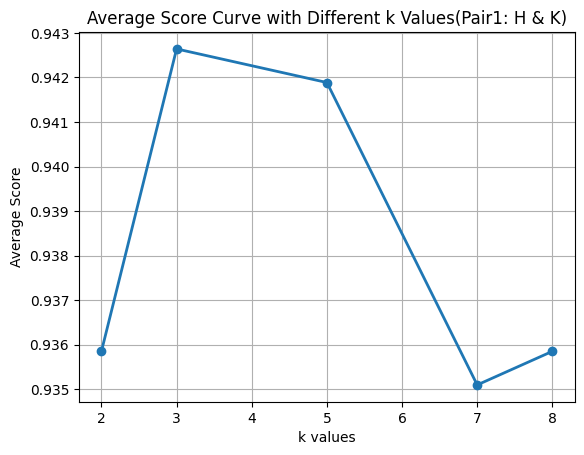

In [37]:

# Shuffle the data
indices = np.random.permutation(len(HK_X_train))

# Divide the data into k-folds
fold_size = len(HK_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_X_train.iloc[training_indices]
    training_labels = HK_y_train.iloc[training_indices]
    validation_features = HK_X_train.iloc[validation_indices]
    validation_labels = HK_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]

start_time = time.time()

final_knn = KNearestNeighbor(k=best_k)
final_knn.train(HK_X_train, HK_y_train)
# Evaluate the final model on the test set
y_pred = final_knn.predict(HK_X_test)
acc = np.mean(y_pred == HK_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")




# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair1: H & K)')
plt.grid(True)
plt.show()

#### 4.1.2.2 Pair 2: M and Y:

k_value: 2, Avg Score: 0.9972
k_value: 3, Avg Score: 0.9979
k_value: 5, Avg Score: 0.9972
k_value: 7, Avg Score: 0.9979
k_value: 8, Avg Score: 0.9979
Accuracy in test set:1.000000
Elapsed time: 29.4347 seconds


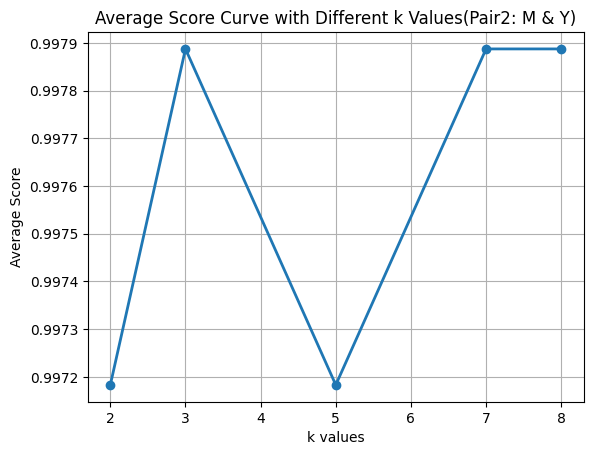

In [38]:

# Shuffle the data
indices = np.random.permutation(len(MY_X_train))

# Divide the data into k-folds
fold_size = len(MY_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_X_train))
# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_X_train.iloc[training_indices]
    training_labels = MY_y_train.iloc[training_indices]
    validation_features = MY_X_train.iloc[validation_indices]
    validation_labels = MY_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]
start_time = time.time()

final_knn = KNearestNeighbor(k=best_k)
final_knn.train(MY_X_train, MY_y_train)
# Evaluate the final model on the test set
y_pred = final_knn.predict(MY_X_test)
acc = np.mean(y_pred == MY_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair2: M & Y)')
plt.grid(True)
plt.show()

#### 4.1.2.3 Pair 3: X and T:

k_value: 2, Avg Score: 0.9958
k_value: 3, Avg Score: 0.9972
k_value: 5, Avg Score: 0.9979
k_value: 7, Avg Score: 0.9958
k_value: 8, Avg Score: 0.9944
Accuracy in test set:0.993711
Elapsed time: 29.9298 seconds


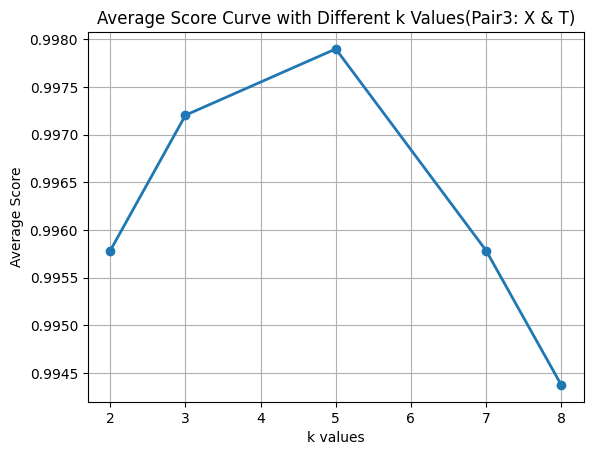

In [39]:

# Shuffle the data
indices = np.random.permutation(len(XT_X_train))

# Divide the data into k-folds
fold_size = len(XT_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_X_train))
# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_X_train.iloc[training_indices]
    training_labels = XT_y_train.iloc[training_indices]
    validation_features = XT_X_train.iloc[validation_indices]
    validation_labels = XT_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]
start_time = time.time()

final_knn = KNearestNeighbor(k=best_k)
final_knn.train(XT_X_train, XT_y_train)
# Evaluate the final model on the test set
y_pred = final_knn.predict(XT_X_test)
acc = np.mean(y_pred == XT_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair3: X & T)')
plt.grid(True)
plt.show()


## 4.2 SVM

In [40]:
class SVM:
    
    def __init__(self, learning_rate=0.01, kernel='linear', gamma=1, degree=3, C=1, bias=True, num_epochs=1000, regularization_param=0.01):
        self.lr = learning_rate
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.bias = bias
        self.reg = regularization_param
        self.num_epochs = num_epochs
        
    def fit(self, X, y):
        n, m = X.shape
        y = y.values.reshape(-1, 1) * 2 - 1  # Convert labels to -1 or 1
        self.X_train = X
        
        if self.kernel == 'linear':
            K = np.dot(X, X.T)
        elif self.kernel == 'poly':
            K = (self.gamma * np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            n = X.shape[0]
            X_norms = np.sum(X.values ** 2, axis=1).reshape((n, 1))
            X_norms_squared = np.tile(X_norms, (1, n))
            distance_squared = X_norms_squared + X_norms_squared.T - 2 * np.dot(X, X.T)
            K = np.exp(-self.gamma * distance_squared)

        self.w = np.zeros((n, 1))
        if self.bias:
            self.b = 0
        else:
            self.b = None
        
        for epoch in range(self.num_epochs):
            y_pred = np.dot(K, self.w) + self.b if self.bias else np.dot(K, self.w)
            loss = np.maximum(0, 1 - y_pred * y).mean() + 0.5 * self.reg * np.sum(self.w ** 2)
            grad_w = np.dot(K.T, -y * (y_pred <= 1)) / n + self.reg * self.w

            self.w = self.w.reshape(-1, 1)
            grad_w = grad_w.reshape(-1, 1)
            self.w -= self.lr * grad_w
            
            if self.bias:
                grad_b = -np.mean(y * (y_pred <= 1))
                self.b -= self.lr * grad_b

    def predict(self, X):
        if self.kernel == 'linear':
            K = np.dot(X, self.w)
        elif self.kernel == 'poly':
            K = (self.gamma * np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            X_arr = X.values
            K = np.exp(-self.gamma * np.sum((X_arr[:, np.newaxis, :] - self.X_train.values) ** 2, axis=2))

        if self.bias:
            return np.sign(np.dot(K, self.w) + self.b).flatten()
        else:
            return np.sign(np.dot(K, self.w)).flatten()



## Data Preparation for SVM
Encode the target value and reset the index.

### 1. Pair 1: H and K

In [41]:
HK = raw_data[raw_data['lettr'].isin(['H', 'K'])]
le = LabelEncoder()
le.fit(HK['lettr'])

# Transform the target column using the LabelEncoder
HK['lettr'] = le.transform(HK['lettr'])
HK = HK.reset_index(drop=True)
HK_X_train, HK_X_test, HK_y_train, HK_y_test = train_test_split(HK.drop('lettr', axis=1), HK['lettr'], test_size=0.1, random_state=514)
# Reset index of HK_X_train
HK_X_train = HK_X_train.reset_index(drop=True)

# Reset index of HK_X_test
HK_X_test = HK_X_test.reset_index(drop=True)

# Reset index of HK_y_train
HK_y_train = HK_y_train.reset_index(drop=True)

# Reset index of HK_y_test
HK_y_test = HK_y_test.reset_index(drop=True)

/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/2039373870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK['lettr'] = le.transform(HK['lettr'])


### 2. Pair 2: M and Y

In [42]:
MY = raw_data[raw_data['lettr'].isin(['M', 'Y'])]
le = LabelEncoder()
le.fit(MY['lettr'])

# Transform the target column using the LabelEncoder
MY['lettr'] = le.transform(MY['lettr'])
MY = MY.reset_index(drop=True)
MY_X_train, MY_X_test, MY_y_train, MY_y_test = train_test_split(MY.drop('lettr', axis=1), MY['lettr'], test_size=0.1, random_state=514)
# Reset index of HK_X_train
MY_X_train = MY_X_train.reset_index(drop=True)

# Reset index of HK_X_test
MY_X_test = MY_X_test.reset_index(drop=True)

# Reset index of HK_y_train
MY_y_train = MY_y_train.reset_index(drop=True)

# Reset index of HK_y_test
MY_y_test = MY_y_test.reset_index(drop=True)

/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/3956562592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MY['lettr'] = le.transform(MY['lettr'])


### 3. Pair 3: X and T

In [43]:
XT = raw_data[raw_data['lettr'].isin(['X', 'T'])]
le = LabelEncoder()
le.fit(XT['lettr'])

# Transform the target column using the LabelEncoder
XT['lettr'] = le.transform(XT['lettr'])
XT = XT.reset_index(drop=True)
XT_X_train, XT_X_test, XT_y_train, XT_y_test = train_test_split(XT.drop('lettr', axis=1), XT['lettr'], test_size=0.1, random_state=514)
# Reset index of HK_X_train
XT_X_train = XT_X_train.reset_index(drop=True)

# Reset index of HK_X_test
XT_X_test = XT_X_test.reset_index(drop=True)

# Reset index of HK_y_train
XT_y_train = XT_y_train.reset_index(drop=True)

# Reset index of HK_y_test
XT_y_test = XT_y_test.reset_index(drop=True)

/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/3235930715.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XT['lettr'] = le.transform(XT['lettr'])


## SVM - Fitting

In [44]:
svm = SVM(kernel='rbf', gamma=0.5)
svm.fit(HK_X_train.reset_index(drop=True), HK_y_train.reset_index(drop=True))
HK_X_test=HK_X_test.reset_index(drop=True)
HK_y_pred = svm.predict(HK_X_test)

#Since it was labeled in 1 and 0, gotta have them using same encoding.
HK_y_pred = np.where(HK_y_pred == -1, 0, HK_y_pred)

acc = np.mean(HK_y_pred == (HK_y_test.reset_index(drop=True)))
print('Accudary:%f' % acc)

Accudary:0.729730


## SVM - Hyper-parameter Tuning Curve

In [45]:
# Define the hyperparameter set
gammas = [0.001, 0.01, 0.1, 1, 10, 100]

# Define the number of folds for k-fold cross-validation
k = 5


## Pair 1: H&K

Gamma: 0.001, Avg Score: 0.5313
Gamma: 0.01, Avg Score: 0.5660
Gamma: 0.1, Avg Score: 0.7540
Gamma: 1, Avg Score: 0.7925
Gamma: 10, Avg Score: 0.7925
Gamma: 100, Avg Score: 0.7925
Accuracy in test set:0.614865
Elapsed time: 2.3600 seconds


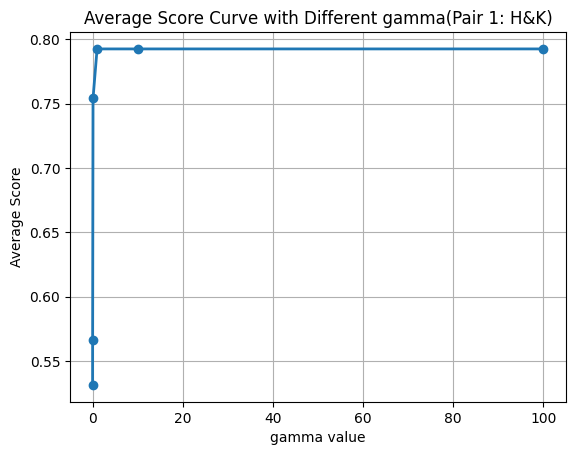

In [46]:

# Shuffle the data
indices = np.random.permutation(len(HK_X_train))

# Divide the data into k-folds
fold_size = len(HK_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_X_train.iloc[training_indices]
    training_labels = HK_y_train.iloc[training_indices]
    validation_features = HK_X_train.iloc[validation_indices]
    validation_labels = HK_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=best_gamma)

start_time = time.time()
final_svm.fit(HK_X_train, HK_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(HK_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == HK_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 1: H&K)')
plt.grid(True)
plt.show()

## Pair 2: M & Y

Gamma: 0.001, Avg Score: 0.5218
Gamma: 0.01, Avg Score: 0.7197
Gamma: 0.1, Avg Score: 0.7930
Gamma: 1, Avg Score: 0.7951
Gamma: 10, Avg Score: 0.7915
Gamma: 100, Avg Score: 0.7915
Accuracy in test set:0.544304
Elapsed time: 3.9984 seconds


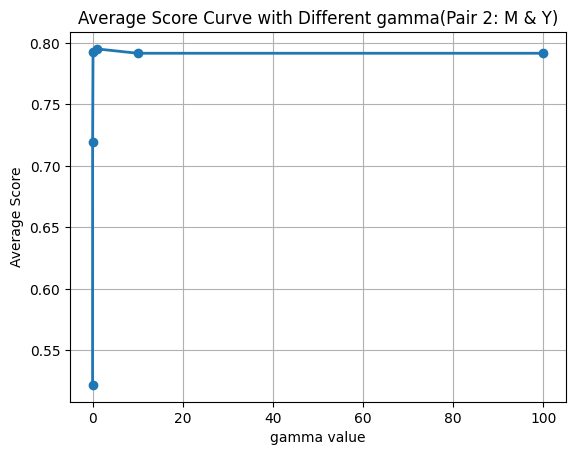

In [47]:

# Shuffle the data
indices = np.random.permutation(len(MY_X_train))

# Divide the data into k-folds
fold_size = len(MY_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_X_train.iloc[training_indices]
    training_labels = MY_y_train.iloc[training_indices]
    validation_features = MY_X_train.iloc[validation_indices]
    validation_labels = MY_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
start_time = time.time()
final_svm = SVM(kernel='rbf',gamma=best_gamma)
final_svm.fit(MY_X_train, MY_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(MY_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == MY_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 2: M & Y)')
plt.grid(True)
plt.show()

## Pair 3: X & T

Gamma: 0.001, Avg Score: 0.5181
Gamma: 0.01, Avg Score: 0.6678
Gamma: 0.1, Avg Score: 0.7794
Gamma: 1, Avg Score: 0.8070
Gamma: 10, Avg Score: 0.7958
Gamma: 100, Avg Score: 0.7958
Accuracy in test set:0.993711
Elapsed time: 2.5137 seconds


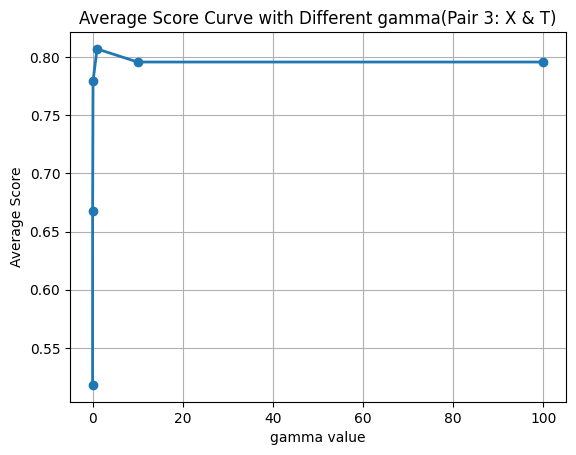

In [48]:

# Shuffle the data
indices = np.random.permutation(len(XT_X_train))

# Divide the data into k-folds
fold_size = len(XT_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_X_train.iloc[training_indices]
    training_labels = XT_y_train.iloc[training_indices]
    validation_features = XT_X_train.iloc[validation_indices]
    validation_labels = XT_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
start_time = time.time()
final_svm = SVM(kernel='rbf',gamma=best_gamma)
final_svm.fit(XT_X_train, XT_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(XT_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == XT_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 3: X & T)')
plt.grid(True)
plt.show()

## Optional Extention 1: Tune more parameters

In [49]:
# Define the hyperparameter set
learning_rate = [0.0001,0.0005, 0.0010,0.0015,0.01,0.015,0.1,0.5,1]

# Define the number of folds for k-fold cross-validation
k = 5


## Pair 1: H & K

Learning Rate: 0.0001, Avg Score: 0.9034
Learning Rate: 0.0005, Avg Score: 0.9034
Learning Rate: 0.001, Avg Score: 0.9034
Learning Rate: 0.0015, Avg Score: 0.9034
Learning Rate: 0.01, Avg Score: 0.7540
Learning Rate: 0.015, Avg Score: 0.7162
Learning Rate: 0.1, Avg Score: 0.5804
Learning Rate: 0.5, Avg Score: 0.5245
Learning Rate: 1, Avg Score: 0.5094
Accuracy in test set:0.891892
Elapsed time: 2.3754 seconds


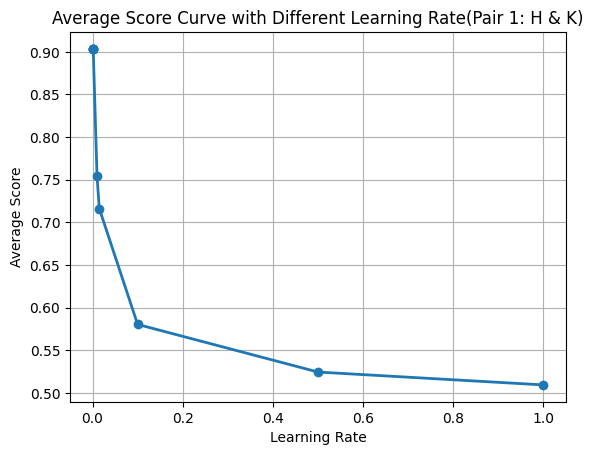

In [50]:

# Shuffle the data
indices = np.random.permutation(len(HK_X_train))

# Divide the data into k-folds
fold_size = len(HK_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_X_train.iloc[training_indices]
    training_labels = HK_y_train.iloc[training_indices]
    validation_features = HK_X_train.iloc[validation_indices]
    validation_labels = HK_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]

start_time = time.time()

final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
final_svm.fit(HK_X_train, HK_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(HK_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == HK_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate(Pair 1: H & K)')
plt.grid(True)
plt.show()

## Pair 2: M & Y

Learning Rate: 0.0001, Avg Score: 0.9592
Learning Rate: 0.0005, Avg Score: 0.9585
Learning Rate: 0.001, Avg Score: 0.9585
Learning Rate: 0.0015, Avg Score: 0.9585
Learning Rate: 0.01, Avg Score: 0.7930
Learning Rate: 0.015, Avg Score: 0.7535
Learning Rate: 0.1, Avg Score: 0.6106
Learning Rate: 0.5, Avg Score: 0.5310
Learning Rate: 1, Avg Score: 0.5162
Accuracy in test set:0.974684
Elapsed time: 4.3615 seconds


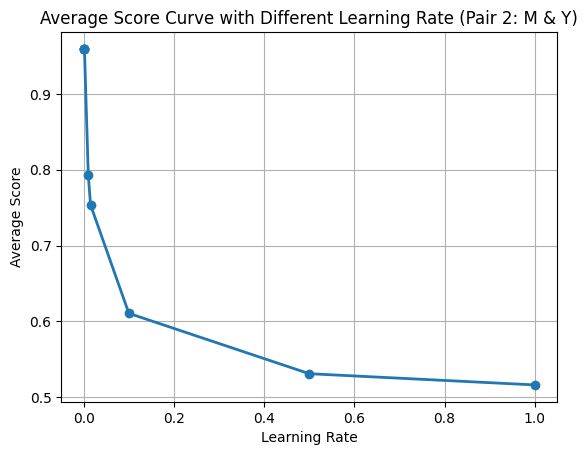

In [51]:
# Shuffle the data
indices = np.random.permutation(len(MY_X_train))

# Divide the data into k-folds
fold_size = len(MY_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_X_train.iloc[training_indices]
    training_labels = MY_y_train.iloc[training_indices]
    validation_features = MY_X_train.iloc[validation_indices]
    validation_labels = MY_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]

start_time = time.time()

final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
final_svm.fit(MY_X_train, MY_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(MY_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == MY_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate (Pair 2: M & Y)')
plt.grid(True)
plt.show()


## Pair 3: X & T

Learning Rate: 0.0001, Avg Score: 0.9782
Learning Rate: 0.0005, Avg Score: 0.9782
Learning Rate: 0.001, Avg Score: 0.9592
Learning Rate: 0.0015, Avg Score: 0.9318
Learning Rate: 0.01, Avg Score: 0.7794
Learning Rate: 0.015, Avg Score: 0.7562
Learning Rate: 0.1, Avg Score: 0.6432
Learning Rate: 0.5, Avg Score: 0.5673
Learning Rate: 1, Avg Score: 0.5442
Accuracy in test set:0.937107
Elapsed time: 2.9804 seconds


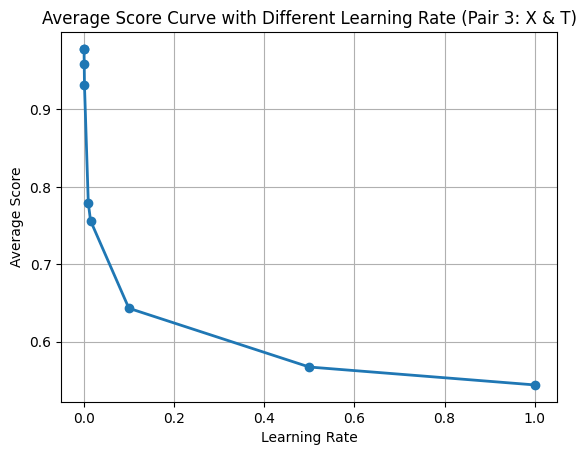

In [52]:
# Shuffle the data
indices = np.random.permutation(len(XT_X_train))

# Divide the data into k-folds
fold_size = len(XT_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_X_train.iloc[training_indices]
    training_labels = XT_y_train.iloc[training_indices]
    validation_features = XT_X_train.iloc[validation_indices]
    validation_labels = XT_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]
start_time = time.time()
final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
final_svm.fit(XT_X_train, XT_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(XT_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == XT_y_test)
print('Accuracy in test set:%f' % acc)


end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate (Pair 3: X & T)')
plt.grid(True)
plt.show()


# 5. Dimension reductions
## 5.1 Filter Methods - For KNN

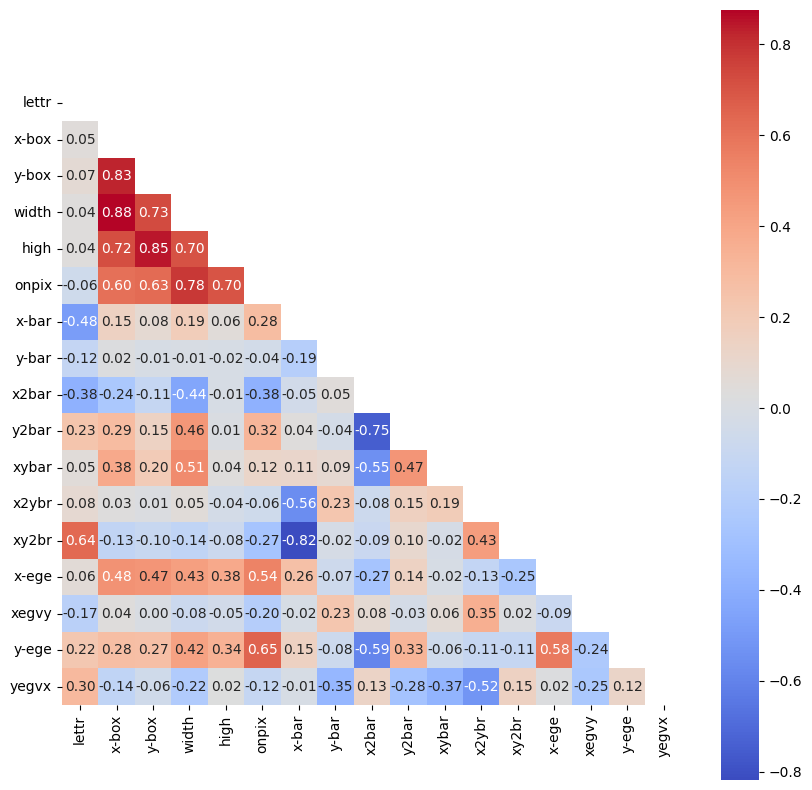

Selected features: {'y-box', 'high', 'width', 'x-box'}


In [53]:

corr = HK.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.show()

corr_df = pd.DataFrame(corr.drop('lettr', axis=1), columns=features[1:], index=features[1:])
corr_df = corr_df.unstack().reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_df = corr_df[corr_df['Feature 1'] != corr_df['Feature 2']]
corr_df['Abs Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

corr_df=pd.DataFrame(corr_df)

corr_df = corr_df.drop('Correlation', axis=1)

# Number of features to keep
num_features_to_keep = 4

# Find the unique features from 'Feature 1' and 'Feature 2' columns
unique_features = set(corr_df['Feature 1'].unique()).union(corr_df['Feature 2'].unique())

# Sort the DataFrame by 'Abs Correlation' in descending order
sorted_corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

# Filter out the most correlated features and only keep the specified number of features
selected_features = set()
for index, row in sorted_corr_df.iterrows():
    if row['Feature 1'] not in selected_features and row['Feature 2'] not in selected_features:
        selected_features.add(row['Feature 1'])
        selected_features.add(row['Feature 2'])
        
        if len(selected_features) >= num_features_to_keep:
            break

# Print the selected features
print("Selected features:", selected_features)
# Define the features to keep

# Create a new DataFrame with only the specified features
HK = raw_data[raw_data['lettr'].isin(['H', 'K'])]
HK_reduced = HK[list(selected_features) + ['lettr']]


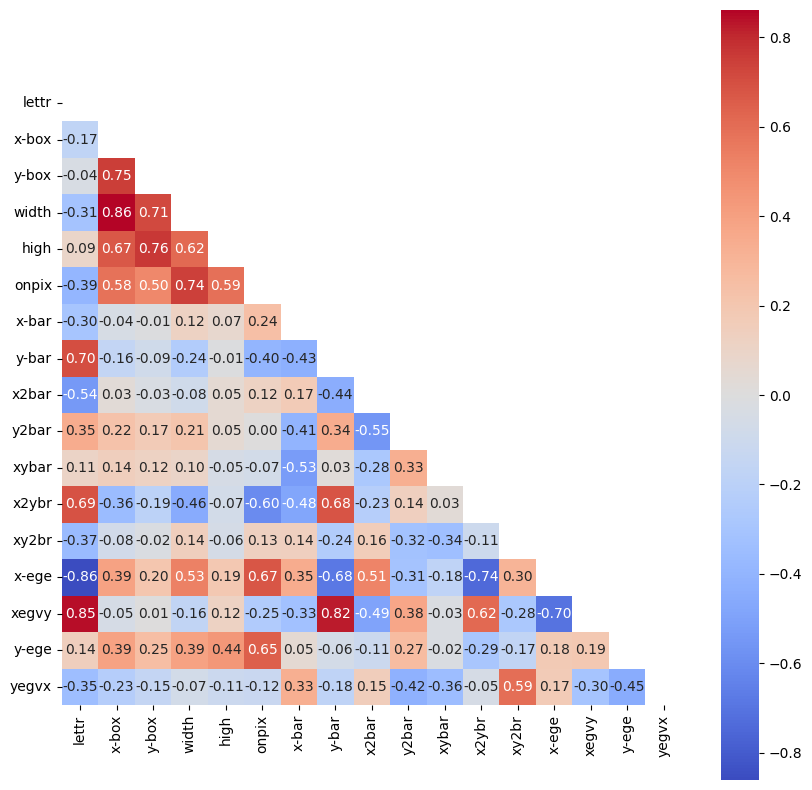

Selected features: {'y-bar', 'xegvy', 'width', 'x-box'}


In [54]:
corr = MY.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.show()

corr_df = pd.DataFrame(corr.drop('lettr', axis=1), columns=features[1:], index=features[1:])
corr_df = corr_df.unstack().reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_df = corr_df[corr_df['Feature 1'] != corr_df['Feature 2']]
corr_df['Abs Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

corr_df=pd.DataFrame(corr_df)

corr_df = corr_df.drop('Correlation', axis=1)

# Number of features to keep
num_features_to_keep = 4

# Find the unique features from 'Feature 1' and 'Feature 2' columns
unique_features = set(corr_df['Feature 1'].unique()).union(corr_df['Feature 2'].unique())

# Sort the DataFrame by 'Abs Correlation' in descending order
sorted_corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

# Filter out the most correlated features and only keep the specified number of features
selected_features = set()
for index, row in sorted_corr_df.iterrows():
    if row['Feature 1'] not in selected_features and row['Feature 2'] not in selected_features:
        selected_features.add(row['Feature 1'])
        selected_features.add(row['Feature 2'])
        
        if len(selected_features) >= num_features_to_keep:
            break

# Print the selected features
print("Selected features:", selected_features)
# Define the features to keep

# Create a new DataFrame with only the specified features
MY = raw_data[raw_data['lettr'].isin(['M', 'Y'])]
MY_reduced = MY[list(selected_features) + ['lettr']]


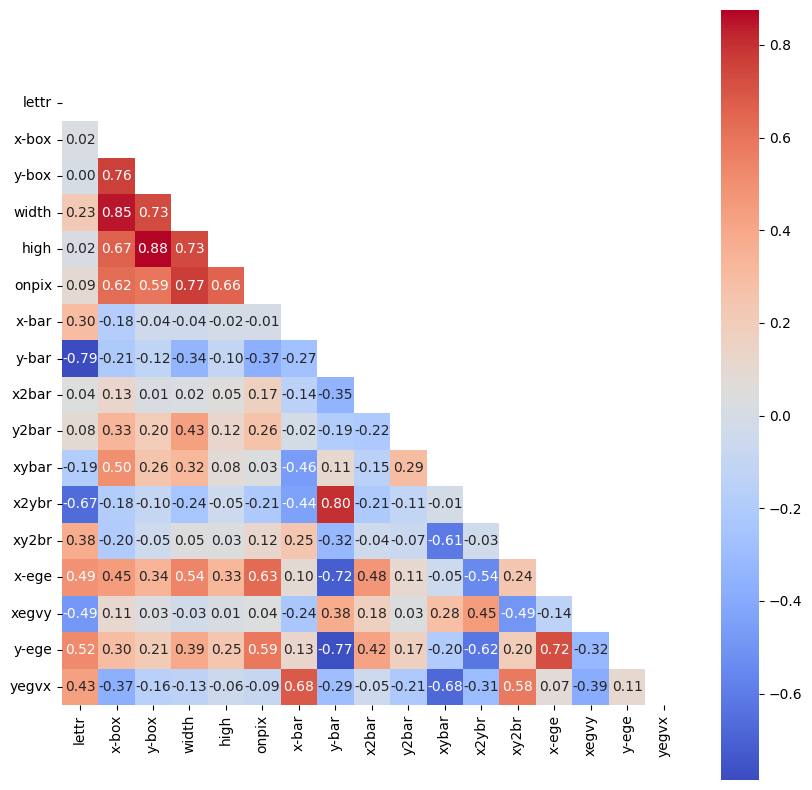

Selected features: {'y-box', 'high', 'width', 'x-box'}


In [55]:
corr = XT.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.show()

corr_df = pd.DataFrame(corr.drop('lettr', axis=1), columns=features[1:], index=features[1:])
corr_df = corr_df.unstack().reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_df = corr_df[corr_df['Feature 1'] != corr_df['Feature 2']]
corr_df['Abs Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

corr_df=pd.DataFrame(corr_df)

corr_df = corr_df.drop('Correlation', axis=1)

# Number of features to keep
num_features_to_keep = 4

# Find the unique features from 'Feature 1' and 'Feature 2' columns
unique_features = set(corr_df['Feature 1'].unique()).union(corr_df['Feature 2'].unique())

# Sort the DataFrame by 'Abs Correlation' in descending order
sorted_corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

# Filter out the most correlated features and only keep the specified number of features
selected_features = set()
for index, row in sorted_corr_df.iterrows():
    if row['Feature 1'] not in selected_features and row['Feature 2'] not in selected_features:
        selected_features.add(row['Feature 1'])
        selected_features.add(row['Feature 2'])
        
        if len(selected_features) >= num_features_to_keep:
            break

# Print the selected features
print("Selected features:", selected_features)

# Define the features to keep
features_to_keep = list(selected_features) + ['lettr']

# Create a new DataFrame with only the specified features
XT = raw_data[raw_data['lettr'].isin(['X', 'T'])]
XT_reduced= XT[list(selected_features) + ['lettr']]

## 5.2 Simple Quality Filtering - For SVM

## HK

In [56]:
le = LabelEncoder()
le.fit(HK['lettr'])

HK['lettr'] = le.transform(HK['lettr'])
HK = HK.reset_index(drop=True)

# Drop the target column 'lettr' to only consider the features
features_df = HK.drop('lettr', axis=1)

# Calculate the variance for each feature
variances = features_df.var()

sorted_variances = variances.sort_values(ascending=False)
# Print the variances
print("Variances for each feature:")
print(sorted_variances)

Variances for each feature:
x2bar    14.070631
y-box    11.027669
y2bar     4.985373
width     4.873223
y-ege     4.846692
high      4.806646
onpix     4.782552
x-box     3.613476
x2ybr     3.524368
x-bar     3.266657
yegvx     2.557472
xybar     2.550577
xy2br     2.549378
x-ege     2.103779
y-bar     1.087691
xegvy     1.019878
dtype: float64


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/2112281918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK['lettr'] = le.transform(HK['lettr'])


## NO significant differences, so I will keep x2bar and y-box, for the rest 2 of the features, I will check their correlation between the target value and keep the best twos.

In [57]:
feature_names = [
    'y2bar', 'width', 'y-ege', 'high', 'onpix', 'x-box', 'x2ybr', 'x-bar',
    'yegvx', 'xybar', 'xy2br', 'x-ege', 'y-bar', 'xegvy'
]

# Calculate the correlation of each feature with 'lettr'
correlations = HK[feature_names].corrwith(HK['lettr'])

# Replace correlations with their absolute values
abs_correlations = np.abs(correlations)

# Sort the absolute correlations in ascending order
sorted_abs_correlations = abs_correlations.sort_values(ascending=False)

# Display the sorted absolute correlations in a formatted output
for feature, corr in sorted_abs_correlations.items():
    print(f"{feature}: {corr:.6f}")

xy2br: 0.636681
x-bar: 0.484837
yegvx: 0.300362
y2bar: 0.234496
y-ege: 0.223971
xegvy: 0.172398
y-bar: 0.119799
x2ybr: 0.081659
onpix: 0.062289
x-ege: 0.057716
xybar: 0.054150
x-box: 0.047121
high: 0.041068
width: 0.036508


In [58]:
selected_features = ['xy2br','x-bar','x2bar','y-box']

# Create a new DataFrame with only the specified features
HK = raw_data[raw_data['lettr'].isin(['H', 'K'])]
HK_reduced= HK[list(selected_features) + ['lettr']]

## MY

In [59]:
le = LabelEncoder()
le.fit(MY['lettr'])

MY['lettr'] = le.transform(MY['lettr'])
MY = MY.reset_index(drop=True)

# Drop the target column 'lettr' to only consider the features
features_df = MY.drop('lettr', axis=1)

# Calculate the variance for each feature
variances = features_df.var()

sorted_variances = variances.sort_values(ascending=False)
# Print the variances
print("Variances for each feature:")
print(sorted_variances)

Variances for each feature:
x-ege    12.244502
y-box    10.686001
x2bar    10.111141
onpix     7.914500
x2ybr     7.332448
xegvy     6.999035
high      6.261547
y-ege     5.445010
width     5.020627
y-bar     4.838568
y2bar     4.471138
x-box     4.436262
x-bar     3.991327
xybar     3.918184
yegvx     2.782600
xy2br     2.046826
dtype: float64


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/1308858497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MY['lettr'] = le.transform(MY['lettr'])


## NO significant differences, so I will keep x2bar, y-ege and y-box, for the rest 2 of the features, I will check their correlation between the target value and keep the best twos.

In [60]:
feature_names = [
    'y2bar', 'width', 'y-ege', 'high', 'onpix', 'x-box', 'x2ybr', 'x-bar',
    'yegvx', 'xybar', 'xy2br', 'x-ege', 'y-bar', 'xegvy'
]

# Calculate the correlation of each feature with 'lettr'
correlations = MY[feature_names].corrwith(MY['lettr'])

# Replace correlations with their absolute values
abs_correlations = np.abs(correlations)

# Sort the absolute correlations in ascending order
sorted_abs_correlations = abs_correlations.sort_values(ascending=False)

# Display the sorted absolute correlations in a formatted output
for feature, corr in sorted_abs_correlations.items():
    print(f"{feature}: {corr:.6f}")

x-ege: 0.860888
xegvy: 0.846127
y-bar: 0.702220
x2ybr: 0.689680
onpix: 0.392978
xy2br: 0.366054
yegvx: 0.348999
y2bar: 0.345059
width: 0.309599
x-bar: 0.301677
x-box: 0.169375
y-ege: 0.143070
xybar: 0.106043
high: 0.092221


In [61]:
selected_features = ['x-ege','y-ege','x2bar','y-box']

# Create a new DataFrame with only the specified features
MY = raw_data[raw_data['lettr'].isin(['M', 'Y'])]
MY_reduced= MY[list(selected_features) + ['lettr']]

## XT

In [62]:
le = LabelEncoder()
le.fit(XT['lettr'])

XT['lettr'] = le.transform(XT['lettr'])
XT = XT.reset_index(drop=True)

# Drop the target column 'lettr' to only consider the features
features_df = XT.drop('lettr', axis=1)

# Calculate the variance for each feature
variances = features_df.var()

sorted_variances = variances.sort_values(ascending=False)
# Print the variances
print("Variances for each feature:")
print(sorted_variances)

Variances for each feature:
y-box    10.922869
y-bar     7.125650
y-ege     5.974302
x2ybr     5.584343
xybar     4.926344
high      4.609886
onpix     3.548097
width     3.396662
x-box     3.321297
y2bar     2.731976
xy2br     2.612502
xegvy     2.475919
yegvx     2.469652
x2bar     2.145394
x-bar     1.875221
x-ege     1.868795
dtype: float64


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/1960571503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XT['lettr'] = le.transform(XT['lettr'])


## NO significant differences, so I will keep y-box, for the rest 3 of the features, I will check their correlation between the target value and keep the best twos.

In [63]:
feature_names = [
    'y2bar', 'width', 'y-ege', 'high', 'onpix', 'x-box', 'x2ybr', 'x-bar',
    'yegvx', 'xybar', 'xy2br', 'x-ege', 'y-bar', 'xegvy'
]

# Calculate the correlation of each feature with 'lettr'
correlations = XT[feature_names].corrwith(XT['lettr'])

# Replace correlations with their absolute values
abs_correlations = np.abs(correlations)

# Sort the absolute correlations in ascending order
sorted_abs_correlations = abs_correlations.sort_values(ascending=False)

# Display the sorted absolute correlations in a formatted output
for feature, corr in sorted_abs_correlations.items():
    print(f"{feature}: {corr:.6f}")

y-bar: 0.786522
x2ybr: 0.667794
y-ege: 0.524820
x-ege: 0.491106
xegvy: 0.487015
yegvx: 0.431775
xy2br: 0.381927
x-bar: 0.301125
width: 0.225648
xybar: 0.191157
onpix: 0.094375
y2bar: 0.084833
x-box: 0.020214
high: 0.017387


In [64]:
selected_features = ['y-bar','x2ybr','y-ege','y-box']

# Create a new DataFrame with only the specified features
XT = raw_data[raw_data['lettr'].isin(['X', 'T'])]
XT_reduced= XT[list(selected_features) + ['lettr']]

# Model Retraining after dimension reduction

## KNN
### Data re-preparation

In [65]:
HK_reduced_X_train, HK_reduced_X_test, HK_reduced_y_train, HK_reduced_y_test = train_test_split(HK_reduced.drop('lettr', axis=1), HK_reduced['lettr'], test_size=0.1, random_state=514)

HK_reduced_X_train = HK_reduced_X_train.reset_index(drop=True)

HK_reduced_X_test = HK_reduced_X_test.reset_index(drop=True)

HK_reduced_y_train = HK_reduced_y_train.reset_index(drop=True)

HK_reduced_y_test = HK_reduced_y_test.reset_index(drop=True)

In [66]:
MY_reduced_X_train, MY_reduced_X_test, MY_reduced_y_train, MY_reduced_y_test = train_test_split(MY_reduced.drop('lettr', axis=1), MY_reduced['lettr'], test_size=0.1, random_state=514)

MY_reduced_X_train = MY_reduced_X_train.reset_index(drop=True)

MY_reduced_X_test = MY_reduced_X_test.reset_index(drop=True)

MY_reduced_y_train = MY_reduced_y_train.reset_index(drop=True)

MY_reduced_y_test = MY_reduced_y_test.reset_index(drop=True)


In [67]:
XT_reduced_X_train, XT_reduced_X_test, XT_reduced_y_train, XT_reduced_y_test = train_test_split(XT_reduced.drop('lettr', axis=1), XT_reduced['lettr'], test_size=0.1, random_state=514)

XT_reduced_X_train = XT_reduced_X_train.reset_index(drop=True)

XT_reduced_X_test = XT_reduced_X_test.reset_index(drop=True)

XT_reduced_y_train = XT_reduced_y_train.reset_index(drop=True)

XT_reduced_y_test = XT_reduced_y_test.reset_index(drop=True)


### 4.1.2 Hyper parameter Tuning for reduced ones
Here I decided to make k the hyper-parameter that I am going to tune. 

In [68]:
# Define the range of parameters to tune
k_values = [3, 5, 8, 10]

# Define the number of folds for k-fold cross-validation
k = 5


#### 4.1.2.1 Pair 1: H and K:


k_value: 3, Avg Score: 0.8709
k_value: 5, Avg Score: 0.8823
k_value: 8, Avg Score: 0.8755
k_value: 10, Avg Score: 0.8845
Accuracy in test set:0.878378
Elapsed time: 25.6600 seconds


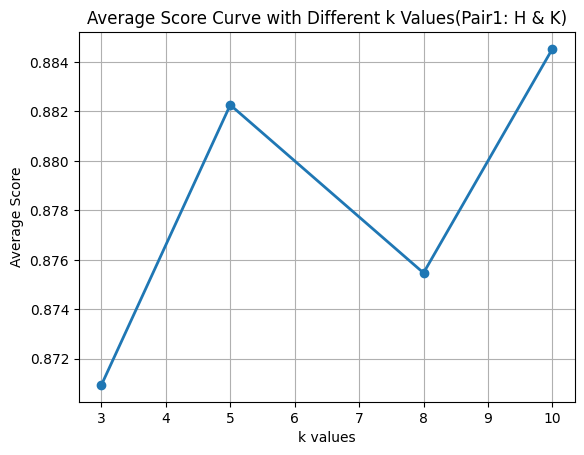

In [69]:
# Shuffle the data
indices = np.random.permutation(len(HK_reduced_X_train))

# Divide the data into k-folds
fold_size = len(HK_reduced_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_reduced_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_reduced_X_train.iloc[training_indices]
    training_labels = HK_reduced_y_train.iloc[training_indices]
    validation_features = HK_reduced_X_train.iloc[validation_indices]
    validation_labels = HK_reduced_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]
start_time = time.time()

final_knn = KNearestNeighbor(k=best_k)
final_knn.train(HK_reduced_X_train, HK_reduced_y_train)

# Evaluate the final model on the test set
y_pred = final_knn.predict(HK_reduced_X_test)
acc = np.mean(y_pred == HK_reduced_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair1: H & K)')
plt.grid(True)
plt.show()



#### 4.1.2.2 Pair 2: M and Y:


k_value: 3, Avg Score: 0.9831
k_value: 5, Avg Score: 0.9831
k_value: 8, Avg Score: 0.9845
k_value: 10, Avg Score: 0.9831
Accuracy in test set:0.981013
Elapsed time: 29.8650 seconds


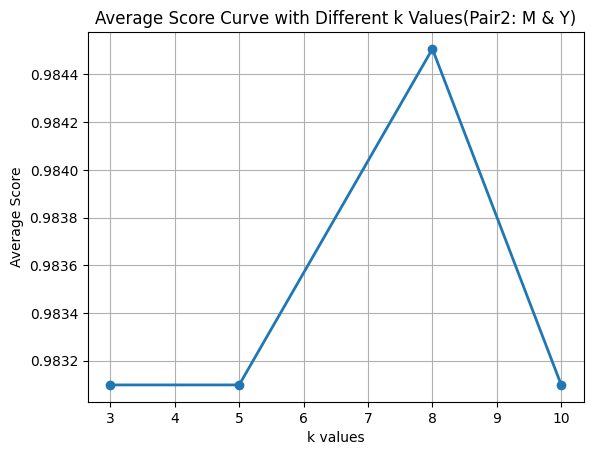

In [70]:
# Shuffle the data
indices = np.random.permutation(len(MY_reduced_X_train))

# Divide the data into k-folds
fold_size = len(MY_reduced_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_reduced_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_reduced_X_train.iloc[training_indices]
    training_labels = MY_reduced_y_train.iloc[training_indices]
    validation_features = MY_reduced_X_train.iloc[validation_indices]
    validation_labels = MY_reduced_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]
final_knn = KNearestNeighbor(k=best_k)
start_time = time.time()
final_knn.train(MY_reduced_X_train, MY_reduced_y_train)

# Evaluate the final model on the test set
y_pred = final_knn.predict(MY_reduced_X_test)
acc = np.mean(y_pred == MY_reduced_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair2: M & Y)')
plt.grid(True)
plt.show()



#### 4.1.2.3 Pair 3: X and T:


k_value: 3, Avg Score: 0.9494
k_value: 5, Avg Score: 0.9515
k_value: 8, Avg Score: 0.9557
k_value: 10, Avg Score: 0.9508
Accuracy in test set:0.968553
Elapsed time: 30.3284 seconds


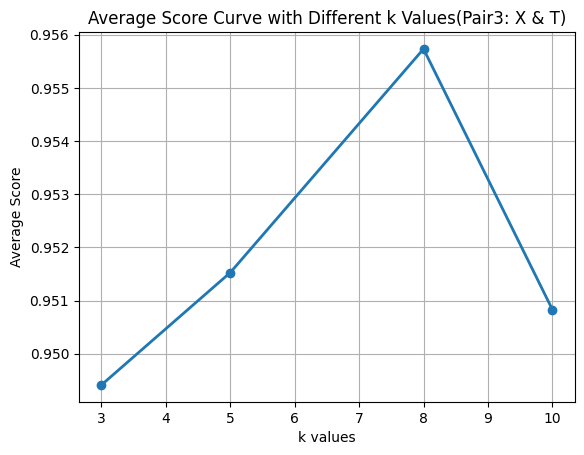

In [71]:
# Shuffle the data
indices = np.random.permutation(len(XT_reduced_X_train))

# Divide the data into k-folds
fold_size = len(XT_reduced_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_reduced_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_reduced_X_train.iloc[training_indices]
    training_labels = XT_reduced_y_train.iloc[training_indices]
    validation_features = XT_reduced_X_train.iloc[validation_indices]
    validation_labels = XT_reduced_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("k_value: {}, Avg Score: {:.4f}".format(k_values[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]

final_knn = KNearestNeighbor(k=best_k)
start_time = time.time()
final_knn.train(XT_reduced_X_train, XT_reduced_y_train)

# Evaluate the final model on the test set
y_pred = final_knn.predict(XT_reduced_X_test)
acc = np.mean(y_pred == XT_reduced_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(k_values, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('k values')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different k Values(Pair3: X & T)')
plt.grid(True)
plt.show()


## SVM Reduced

### Data Preparation

### 1. Pair 1: H and K

In [72]:
le = LabelEncoder()
le.fit(HK_reduced['lettr'])

# Transform the target column using the LabelEncoder
HK_reduced['lettr'] = le.transform(HK_reduced['lettr'])
HK_reduced = HK_reduced.reset_index(drop=True)
HK_reduced_X_train, HK_reduced_X_test, HK_reduced_y_train, HK_reduced_y_test = train_test_split(HK_reduced.drop('lettr', axis=1), HK_reduced['lettr'], test_size=0.1, random_state=514)

# Reset index of HK_reduced_X_train
HK_reduced_X_train = HK_reduced_X_train.reset_index(drop=True)

# Reset index of HK_reduced_X_test
HK_reduced_X_test = HK_reduced_X_test.reset_index(drop=True)

# Reset index of HK_reduced_y_train
HK_reduced_y_train = HK_reduced_y_train.reset_index(drop=True)

# Reset index of HK_reduced_y_test
HK_reduced_y_test = HK_reduced_y_test.reset_index(drop=True)


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/234716455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK_reduced['lettr'] = le.transform(HK_reduced['lettr'])


### 2. Pair 2: M and Y

In [73]:
le = LabelEncoder()
le.fit(MY_reduced['lettr'])

# Transform the target column using the LabelEncoder
MY_reduced['lettr'] = le.transform(MY_reduced['lettr'])
MY_reduced = MY_reduced.reset_index(drop=True)
MY_reduced_X_train, MY_reduced_X_test, MY_reduced_y_train, MY_reduced_y_test = train_test_split(MY_reduced.drop('lettr', axis=1), MY_reduced['lettr'], test_size=0.1, random_state=514)

# Reset index of MY_reduced_X_train
MY_reduced_X_train = MY_reduced_X_train.reset_index(drop=True)

# Reset index of MY_reduced_X_test
MY_reduced_X_test = MY_reduced_X_test.reset_index(drop=True)

# Reset index of MY_reduced_y_train
MY_reduced_y_train = MY_reduced_y_train.reset_index(drop=True)

# Reset index of MY_reduced_y_test
MY_reduced_y_test = MY_reduced_y_test.reset_index(drop=True)


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/608139830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MY_reduced['lettr'] = le.transform(MY_reduced['lettr'])


### 3. Pair 3: X and T

In [74]:
le = LabelEncoder()
le.fit(XT_reduced['lettr'])

# Transform the target column using the LabelEncoder
XT_reduced['lettr'] = le.transform(XT_reduced['lettr'])
XT_reduced = XT_reduced.reset_index(drop=True)
XT_reduced_X_train, XT_reduced_X_test, XT_reduced_y_train, XT_reduced_y_test = train_test_split(XT_reduced.drop('lettr', axis=1), XT_reduced['lettr'], test_size=0.1, random_state=514)

# Reset index of XT_reduced_X_train
XT_reduced_X_train = XT_reduced_X_train.reset_index(drop=True)

# Reset index of XT_reduced_X_test
XT_reduced_X_test = XT_reduced_X_test.reset_index(drop=True)

# Reset index of XT_reduced_y_train
XT_reduced_y_train = XT_reduced_y_train.reset_index(drop=True)

# Reset index of XT_reduced_y_test
XT_reduced_y_test = XT_reduced_y_test.reset_index(drop=True)


/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_5324/2533738197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XT_reduced['lettr'] = le.transform(XT_reduced['lettr'])


## SVM - Hyper-parameter Tuning Curve

In [75]:
# Define the hyperparameter set
gammas = [0.001, 0.01, 0.1, 1, 10, 100]

# Define the number of folds for k-fold cross-validation
k = 5


## Pair 1: H&K

Gamma: 0.001, Avg Score: 0.5675
Gamma: 0.01, Avg Score: 0.5577
Gamma: 0.1, Avg Score: 0.7283
Gamma: 1, Avg Score: 0.9004
Gamma: 10, Avg Score: 0.8106
Gamma: 100, Avg Score: 0.8106
Accuracy in test set:0.851351
Elapsed time: 1.8586 seconds


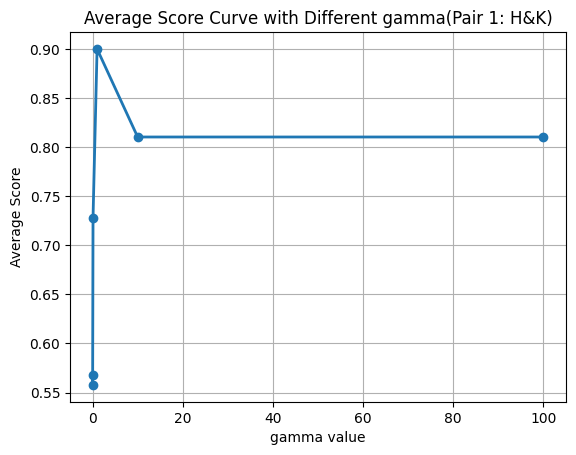

In [83]:
# Shuffle the data
indices = np.random.permutation(len(HK_reduced_X_train))

# Divide the data into k-folds
fold_size = len(HK_reduced_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_reduced_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_reduced_X_train.iloc[training_indices]
    training_labels = HK_reduced_y_train.iloc[training_indices]
    validation_features = HK_reduced_X_train.iloc[validation_indices]
    validation_labels = HK_reduced_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=best_gamma)
start_time = time.time()
final_svm.fit(HK_reduced_X_train, HK_reduced_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(HK_reduced_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == HK_reduced_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")


# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 1: H&K)')
plt.grid(True)
plt.show()


## Pair 2: M & Y

Gamma: 0.001, Avg Score: 0.5218
Gamma: 0.01, Avg Score: 0.7197
Gamma: 0.1, Avg Score: 0.7930
Gamma: 1, Avg Score: 0.7951
Gamma: 10, Avg Score: 0.7915
Gamma: 100, Avg Score: 0.7915
Accuracy in test set:0.544304
Elapsed time: 3.1092 seconds


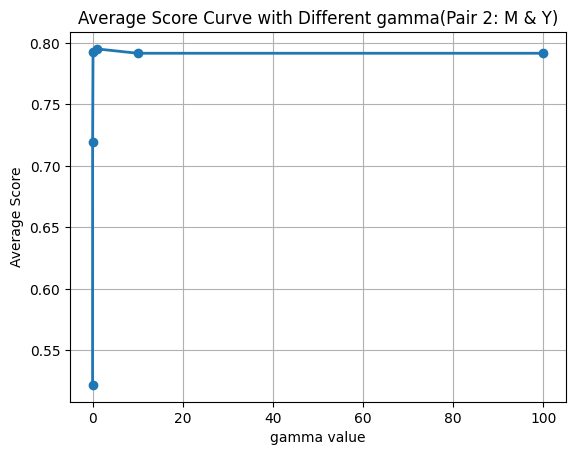

In [84]:

# Shuffle the data
indices = np.random.permutation(len(MY_X_train))

# Divide the data into k-folds
fold_size = len(MY_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_X_train.iloc[training_indices]
    training_labels = MY_y_train.iloc[training_indices]
    validation_features = MY_X_train.iloc[validation_indices]
    validation_labels = MY_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=best_gamma)
start_time = time.time()
final_svm.fit(MY_X_train, MY_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(MY_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == MY_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")


# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 2: M & Y)')
plt.grid(True)
plt.show()

## Pair 3: X & T

Gamma: 0.001, Avg Score: 0.5181
Gamma: 0.01, Avg Score: 0.6678
Gamma: 0.1, Avg Score: 0.7794
Gamma: 1, Avg Score: 0.8070
Gamma: 10, Avg Score: 0.7958
Gamma: 100, Avg Score: 0.7958
Accuracy in test set:0.993711
Elapsed time: 2.5544 seconds


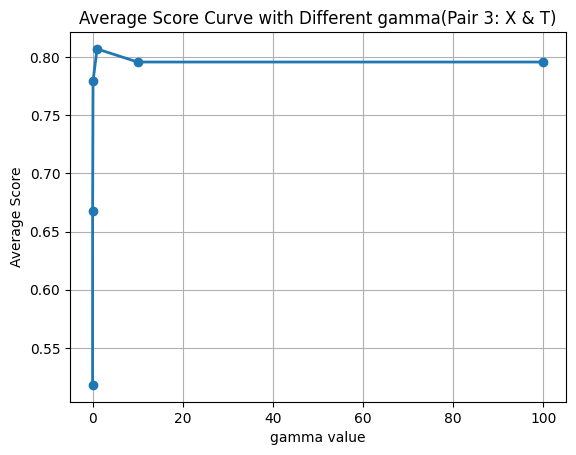

In [85]:

# Shuffle the data
indices = np.random.permutation(len(XT_X_train))

# Divide the data into k-folds
fold_size = len(XT_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_X_train.iloc[training_indices]
    training_labels = XT_y_train.iloc[training_indices]
    validation_features = XT_X_train.iloc[validation_indices]
    validation_labels = XT_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for gamma_value in gammas:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=gamma_value)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(gammas)):
    k_scores = scores[i::len(gammas)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Gamma: {}, Avg Score: {:.4f}".format(gammas[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_gamma = gammas[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=best_gamma)
start_time = time.time()
final_svm.fit(XT_X_train, XT_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(XT_X_test)
y_pred[y_pred==-1] = 0

acc = np.mean(y_pred == XT_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(gammas, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('gamma value')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different gamma(Pair 3: X & T)')
plt.grid(True)
plt.show()

## Optional Extention 1: Tune more parameters

In [79]:
# Define the hyperparameter set
learning_rate = [0.0001,0.0005, 0.0010,0.0015,0.01,0.015,0.1,0.5,1]

# Define the number of folds for k-fold cross-validation
k = 5


## Pair 1: H & K

Learning Rate: 0.0001, Avg Score: 0.9034
Learning Rate: 0.0005, Avg Score: 0.9034
Learning Rate: 0.001, Avg Score: 0.9034
Learning Rate: 0.0015, Avg Score: 0.9034
Learning Rate: 0.01, Avg Score: 0.7540
Learning Rate: 0.015, Avg Score: 0.7162
Learning Rate: 0.1, Avg Score: 0.5804
Learning Rate: 0.5, Avg Score: 0.5245
Learning Rate: 1, Avg Score: 0.5094
Accuracy in test set:0.891892
Elapsed time: 2.0757 seconds


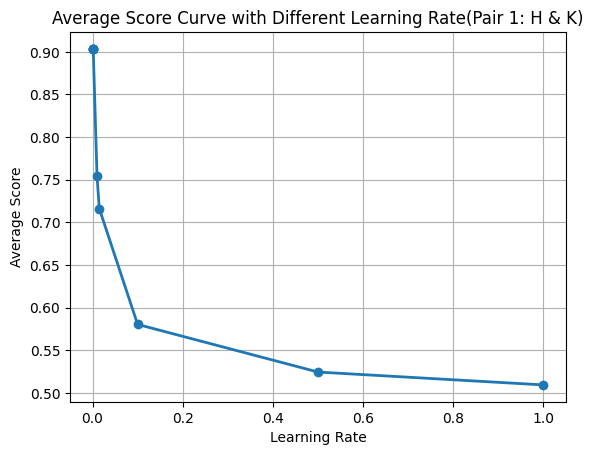

In [86]:

# Shuffle the data
indices = np.random.permutation(len(HK_X_train))

# Divide the data into k-folds
fold_size = len(HK_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_X_train.iloc[training_indices]
    training_labels = HK_y_train.iloc[training_indices]
    validation_features = HK_X_train.iloc[validation_indices]
    validation_labels = HK_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
start_time = time.time()
final_svm.fit(HK_X_train, HK_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(HK_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == HK_y_test)
print('Accuracy in test set:%f' % acc)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")


# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate(Pair 1: H & K)')
plt.grid(True)
plt.show()

## Pair 2: M & Y

Learning Rate: 0.0001, Avg Score: 0.9592
Learning Rate: 0.0005, Avg Score: 0.9585
Learning Rate: 0.001, Avg Score: 0.9585
Learning Rate: 0.0015, Avg Score: 0.9585
Learning Rate: 0.01, Avg Score: 0.7930
Learning Rate: 0.015, Avg Score: 0.7535
Learning Rate: 0.1, Avg Score: 0.6106
Learning Rate: 0.5, Avg Score: 0.5310
Learning Rate: 1, Avg Score: 0.5162
Accuracy in test set:0.974684
Elapsed time: 4.0701 seconds


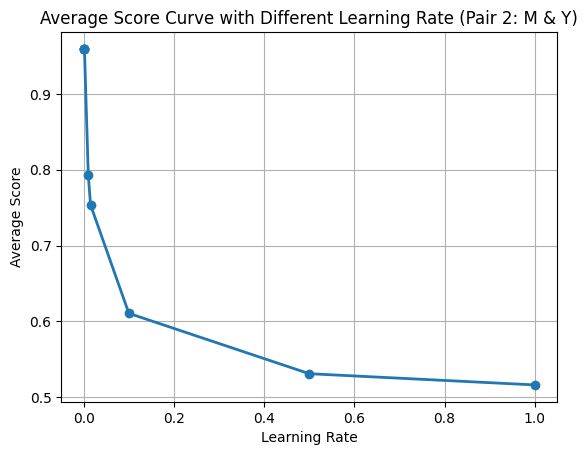

In [87]:
# Shuffle the data
indices = np.random.permutation(len(MY_X_train))

# Divide the data into k-folds
fold_size = len(MY_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(MY_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = MY_X_train.iloc[training_indices]
    training_labels = MY_y_train.iloc[training_indices]
    validation_features = MY_X_train.iloc[validation_indices]
    validation_labels = MY_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
start_time = time.time()
final_svm.fit(MY_X_train, MY_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(MY_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == MY_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")


# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate (Pair 2: M & Y)')
plt.grid(True)
plt.show()


## Pair 3: X & T

Learning Rate: 0.0001, Avg Score: 0.9782
Learning Rate: 0.0005, Avg Score: 0.9782
Learning Rate: 0.001, Avg Score: 0.9592
Learning Rate: 0.0015, Avg Score: 0.9318
Learning Rate: 0.01, Avg Score: 0.7794
Learning Rate: 0.015, Avg Score: 0.7562
Learning Rate: 0.1, Avg Score: 0.6432
Learning Rate: 0.5, Avg Score: 0.5673
Learning Rate: 1, Avg Score: 0.5442
Accuracy in test set:0.937107
Elapsed time: 2.4874 seconds


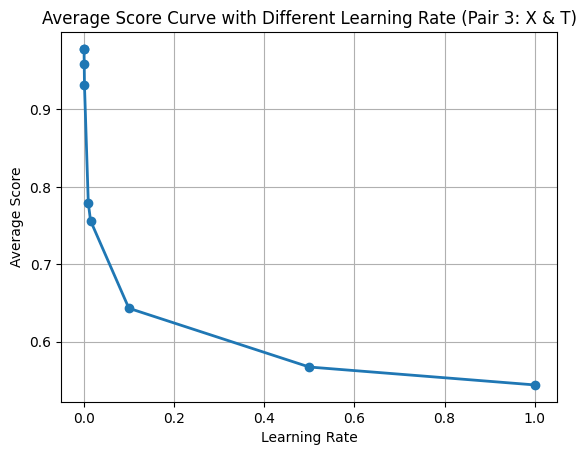

In [88]:
# Shuffle the data
indices = np.random.permutation(len(XT_X_train))

# Divide the data into k-folds
fold_size = len(XT_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(XT_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = XT_X_train.iloc[training_indices]
    training_labels = XT_y_train.iloc[training_indices]
    validation_features = XT_X_train.iloc[validation_indices]
    validation_labels = XT_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for lr in learning_rate:
        # Create a KNearestNeighbor model
        svm = SVM(kernel='rbf',gamma=0.1,learning_rate=lr)
        
        # Train the model on the training set
        svm.fit(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = svm.predict(validation_features)
        y_pred = np.where(y_pred == -1, 0, validation_labels)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(learning_rate)):
    k_scores = scores[i::len(learning_rate)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)
    print("Learning Rate: {}, Avg Score: {:.4f}".format(learning_rate[i], avg_score))
    

# Find the best k value and train the final model on the entire training set
best_lr = learning_rate[np.argmax(avg_scores)]
final_svm = SVM(kernel='rbf',gamma=0.1,learning_rate=best_lr)
start_time = time.time()
final_svm.fit(XT_X_train, XT_y_train)

# Evaluate the final model on the test set
y_pred = final_svm.predict(XT_X_test)
y_pred[y_pred==-1] = 0
acc = np.mean(y_pred == XT_y_test)
print('Accuracy in test set:%f' % acc)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# Plot the average score curve with different k values
plt.plot(learning_rate, avg_scores, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Average Score')
plt.title('Average Score Curve with Different Learning Rate (Pair 3: X & T)')
plt.grid(True)
plt.show()
